# Percentile method

The goal is to show that causal impact is not related necessarily to the most central node. What defines a node to be most central depends on the context. Often a assumption of "connectedness" is made, i.e. nodes with high degree are deemed more important than nodes with lesser degree. What we propose is an alternative method using information theory which has several advantages. Primarily, information theory uses probability distributions, allowing (1) observation only to be used in ranking node on dynamic importance, and (2) are blind of the mechanisms that generate to these distributions; This allows for mapping dynamic importance in situations where there is no clear way, or no current method that allows for causal analysis of the system, e.g. the climate or complex-networks such as protein-protein networks.

Consequently, we hypothesize that nodes with that rank high in terms of centrality, does not necessarily reflect nodes with high causal impact. The metrics proposes, informational impact, in contrast is able to accurately reflect causal impact in complex dynamical networks

## The method
The direct hypothesis is that centrality metrics does not necessarily reflect high causal impact. Causal impact is defined as the integral of the KL-divergence between an intervened and unintervened distribution. Informational impact is defined similarly but using the probabilitiy distributions using the unintervened distribution. How can we assure that there exists only one driver-node in the network? In reality, we can't as it is currently unclear how to identify driver-nodes in complex dynamical networks; as such we extract the area under the curve per node for causal impact. The area under the curve, however, will not guarantee a singular node to be the driver-node in any arbritrary network structure. As such we porpose a method that exracts the number of driver-nodes using overlapping confidence interval method. This method extracts the max area under the curve value per simulations after which a confidence intervals are computed and estimated how many driver-nodes are present in this label-vector (figure X). 

The driver-set will be used as label indicator. We hypothesize that on average the percentile of informational impact will be higher for nodes identified as causally important than for any centrality metrics. 


In [54]:
import sys, os
sys.path.insert(0, '../')
from matplotlib import style
style.use('seaborn-poster')
import matplotlib.pyplot as plt, numpy as np, networkx as nx
from Utils.stats import driverNodeEstimate
from Utils import IO

fn = 'tester.pickle'
for k, v in IO.loadPickle(fn).items():
    print(f'Loading {k}')
    globals()[k] = v

    
s = next(iter(settings))
setting = settings[s]


Loading aucs
Loading data
Loading rdata
Loading settings


In [174]:
from scipy.stats import percentileofscore as pcs
# estimate the max values
# tmp = np.array([i for i in aucs.values()])

from itertools import product
# ndata, nodes, ntrials, npulse, ntemp = tmp.shape
combinations = product(*[data.keys(), range(npulse), range(ntemp)])


    
# driverNodes = {key : np.zeros(npulse, ntemp, dtype = set) for key in data.keys()}
# driverNodes = np.zeros((ndata, npulse, ntemp), dtype = set)
# overlaps = {key : }
# overlaps    = np.zeros((ndata, npulse, ntemp), dtype = float)
alpha = .05

idx = tmp.argmax(1) 



centralities = dict(\
                   degree = nx.degree_centrality,\
                   betweenness = nx.betweenness_centrality,\
                   closeness  = nx.closeness_centrality,\
                   eigenvector = nx.eigenvector_centrality,\
#                    current_flow = nx.current_flow_betweenness_centrality,\
                   )


conditions = len(centralities) + 1

overlaps    = {}
driverNodes = {}
pscores = {}

taucs = {}

from scipy import integrate
for key in data:
    driverNodes[key] = np.zeros((npulse, ntemp), dtype = set)
    overlaps[key] = np.zeros((npulse, ntemp), dtype = float)
    pscores[key] = np.zeros((npulse, ntemp, conditions))
    
    taucs[key] = np.trapz(data.get(key), axis = -1)


kind = 'weak'
for (dataidx, pulseidx, tempidx) in combinations:
    
    graph = settings[dataidx].get('graph')
    model = settings[dataidx].get('model')
    model = model(graph)
    
    idx   = aucs.get(dataidx)
    ranks = idx[..., pulseidx, tempidx].argmax(0)
#     print(dataidx, pulseidx, tempidx, ranks)
    drivers = driverNodeEstimate(ranks.tolist(), alpha = alpha)
    
    driverNodes[dataidx][pulseidx, tempidx] = drivers
    
    midrivers = driverNodes[dataidx][0, tempidx]
    
    inter = drivers.intersection(midrivers)
    union = drivers.union(midrivers)

    overlap = len(inter) / len(union)
    overlaps[dataidx][pulseidx, tempidx] = overlap 
    
    
    d = aucs[dataidx][:, :, 0, tempidx]
    d = d.mean(1) # average over trials
    
    e = d[list(drivers)]
#     d = [i for idx, i in enumerate(d) if idx not in drivers] 
#     d = np.array(d)
    
    score = np.mean([pcs(d, i, kind = kind) for i in e])
    
#     print('>>', dataidx, pulseidx, tempidx)
#     print(drivers, score)
    pscores[dataidx][pulseidx, tempidx, 0] = score
    
 
#     print(graph.nodes, dataidx)
#     print(dataidx, drivers)
    for cidx, (cent, cf) in enumerate(centralities.items()):
        centVals = cf(model.graph)
        
        vals = [centVals.get(model.rmapping[d]) for d in drivers]
#         print(vals)
        d = np.fromiter(centVals.values(), dtype = 'float')
#         d = [i for idx, i in enumerate(d) if idx not in drivers]
#         d = np.array(d)
        score = np.mean([pcs(d, i, kind = kind) for i in vals])
#         print(score)
        pscores[dataidx][pulseidx, tempidx, cidx + 1] = score
        
        
#         for d in drivers:
            
        
#     print(dataidx, pulseidx, tempidx, overlap, midrivers, drivers) 

/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


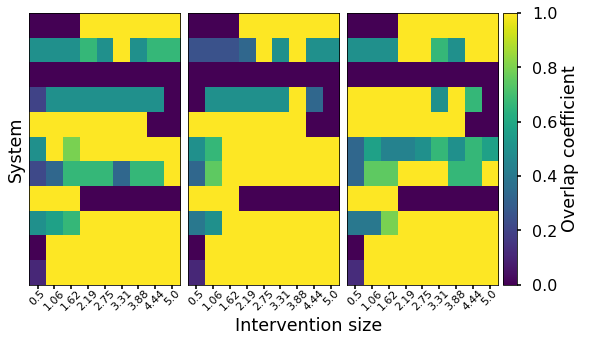

In [147]:
pulses = setting.get('pulseSizes')
xr = np.arange(len(pulses))
fig, ax = plt.subplots(1, ntemp, figsize = (10, 5), \
                       sharex = 'all', sharey = 'all')
for temp in range(ntemp):
    tax = ax[temp]
    h = tax.imshow([i[1:, temp] for i in overlaps.values()], \
                   vmin = 0, vmax = 1, aspect = 'auto')
    tax.set_yticks([])
    tax.set_xticks(xr)
    tax.set_xticklabels(np.round(pulses, 2), \
                    rotation = 45, fontsize = 11,\
                    )
    tax.tick_params(axis = 'x', pad = .1)
    
fig.subplots_adjust(wspace = 0.05)
mainax = fig.add_subplot(111, xticks = [], yticks = [], frameon = 0)
mainax.set_xlabel('Intervention size', labelpad = 32)
ax[0].set_ylabel('System')
fig.colorbar(h, ax = ax, label = 'Overlap coefficient', pad = 0.01)

fig.show()

In [149]:
for k, v in settings.items():
    print(v['modelSettings'])

{'magSide': 'neg', 'updateType': '0.25', 'nudgeType': 'constant'}
{'magSide': 'neg', 'updateType': '0.25', 'nudgeType': 'constant'}
{'magSide': 'neg', 'updateType': '0.25', 'nudgeType': 'constant'}
{'magSide': 'neg', 'updateType': '0.25', 'nudgeType': 'constant'}
{'magSide': 'neg', 'updateType': '0.25', 'nudgeType': 'constant'}
{'magSide': 'neg', 'updateType': '0.25', 'nudgeType': 'constant'}
{'magSide': 'neg', 'updateType': '0.25', 'nudgeType': 'constant'}
{'magSide': 'neg', 'updateType': '0.25', 'nudgeType': 'constant'}
{'magSide': 'neg', 'updateType': '0.25', 'nudgeType': 'constant'}
{'magSide': 'neg', 'updateType': '0.25', 'nudgeType': 'constant'}
{'magSide': 'neg', 'updateType': '0.25', 'nudgeType': 'constant'}


/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Use the colorbar set_ticks() method instead.
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


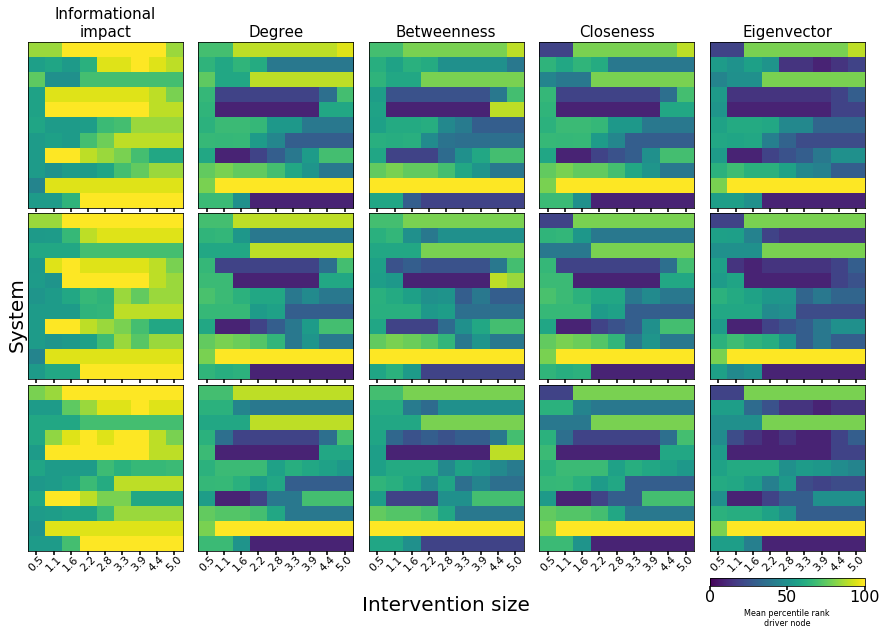

In [258]:
%matplotlib inline

gs = dict(height_ratios = [1, 1, 1, .1, .05])
# now use the driver nodes to estimate the percentiles
fig, ax = plt.subplots(ntemp + 2,\
                       conditions,\
                      sharey = 'row',\
                      gridspec_kw = gs,\
                      figsize = (15, 10))

conditionLabels = ['Informational\nimpact', *list(centralities.keys())]
conditionLabels = [i.replace('_', '\n').capitalize() for i in conditionLabels]
for condition in range(conditions):
    for temp in range(ntemp):
        tax = ax[temp, condition]
        tax.set_yticks([])
        tax.set_xticks(xr)
        tax.set_xticklabels(np.round(pulses, 1), rotation = 45, \
                            fontsize = 11)
        
        tax.tick_params(axis = 'x',\
                       pad = 0.1)
        if temp == 0:
            title = conditionLabels[condition].replace('_', '\n').capitalize()
            tax.set_title(title, fontsize = 15)
        
        h = tax.imshow([i[1:, temp, condition] for i in pscores.values()], \
                       vmin = 0, vmax = 100, aspect = 'auto',\
#                       )
                      interpolation = None)
        
        
        if condition == conditions - 1 and temp == ntemp -1 :
            plt.colorbar(h, cax = ax[-1,condition], orientation = 'horizontal')
#             fig.colorbar(h, cax = ax[-1, condition], orientation = 'horitzontal')

for axi in ax[-2:, :].ravel()[:-1]:
    axi.axis('off')
ax[-1, -1].set_xticks([0, 100])
ax[-1, -1].tick_params(axis = 'x', pad = 0.01)
ax[-1, -1].set_xlabel('Mean percentile rank\ndriver node', fontsize = 8)

fig.subplots_adjust(hspace = .05, wspace = .10)
# fig.colorbar(h, ax = ax[:2, :], pad = .01, \
#              label = 'Average percentile score of drivers')
mainax = fig.add_subplot(111, frameon = 0, \
                        xticks = [],\
                        yticks = [])
mainax.set_xlabel('Intervention size', fontsize = 20,  labelpad = 10)
mainax.set_ylabel('System', fontsize = 20, labelpad = 1.5)
fig.show()


<IPython.core.display.Javascript object>


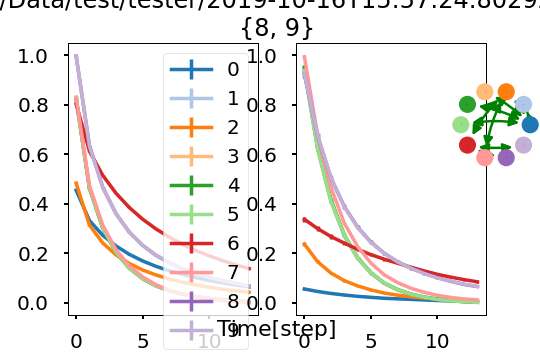

interactive(children=(Select(description='dataName', options=('../Data/test/tester/2019-10-16T15:57:24.802926'…

In [191]:
import ipywidgets as widgets
from scipy.stats import sem


%matplotlib notebook
# dataSlider = widgets.SelectionSlider(options = data.keys())
dataSlider = widgets.Select(options = data.keys())
tempSlider = widgets.IntSlider(min = 0, max = 2)
pulseSlider = widgets.IntSlider(min = 1, max = 9)


fig, (left, right) = plt.subplots(1, 2)
mainax = fig.add_subplot(111, frameon = 0,\
                        xticks = [],\
                        yticks = [])
mainax.set_xlabel('Time[step]')
# inax.axis('off')
@widgets.interact(dataName = dataSlider, \
                  temp = tempSlider, \
                  pulse = pulseSlider)
def update(dataName, temp, pulse):
    d = data.get(dataName)
    
    for idx, i in enumerate(data.keys()):
        if i == dataName:
            break
    drivers = driverNodes[dataName][pulse, temp]
    
    mainax.set_title(dataName + "\n" + str(drivers))
    g = settings.get(dataName).get('graph')
    
    nodes, trials, pulses, temps, deltas = d.shape
    colors = plt.cm.tab20(range(nodes))
    means = d.mean(1)
    sems  =  2 * sem(d, axis = 1)
    xr = np.arange(d.shape[-1])
    
    left.cla(); right.cla()
    
    inax = right.inset_axes([.8, 0.4, .5, .6])
    addGraphPretty(g, ax = inax)
    inax.axis('off')
    for node in range(nodes):
        left.errorbar(xr, means[node, 0, temp], sems[node, 0, temp], color = colors[node], label = node)
        right.errorbar(xr, means[node, pulse, temp], sems[node, pulse, temp], color = colors[node])
    left.legend()


../Data/test/tester/2019-10-16T15:57:24.802926
../Data/test/tester/2019-10-14T07:46:53.453355/2019-10-14T07:46:53.453355
../Data/test/tester/2019-10-16T10:54:59.050361
../Data/test/tester/2019-10-07T12:37:57.770156/2019-10-07T12:37:57.770156
../Data/test/tester/2019-10-07T12:38:01.219213/2019-10-07T12:38:01.219213
../Data/test/tester/2019-10-14T07:46:52.816297/2019-10-14T07:46:52.816297
../Data/test/tester/2019-10-14T07:46:55.128018/2019-10-14T07:46:55.128018
../Data/test/tester/2019-10-07T12:37:59.585120/2019-10-07T12:37:59.585120
../Data/test/tester/2019-10-16T10:54:48.274841
../Data/test/tester/2019-10-14T07:47:19.581611/2019-10-14T07:47:19.581611
../Data/test/tester/2019-10-16T10:54:48.281020
(10, 30, 10, 3)


<IPython.core.display.Javascript object>


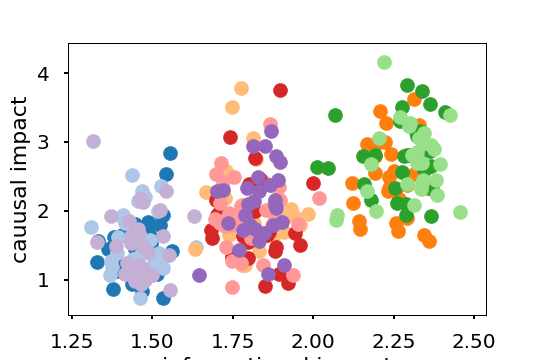

[Text(0, 0.5, 'cauusal impact'), Text(0.5, 0, 'informational impact')]

In [153]:
for i in data.keys():
    print(i)
    
tmp = taucs['../Data/test/tester/2019-10-14T07:46:55.128018/2019-10-14T07:46:55.128018']
# tmp = tmp.mean(1)
print(tmp.shape)
colors = plt.cm.tab20(range(10))
fig, ax = plt.subplots()
for i in range(10):
    xy = tmp[i, :, [0, 2], 0]
    ax.scatter(*xy, color = colors[i])

ax.set(xlabel = 'informational impact', ylabel = 'cauusal impact')

/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


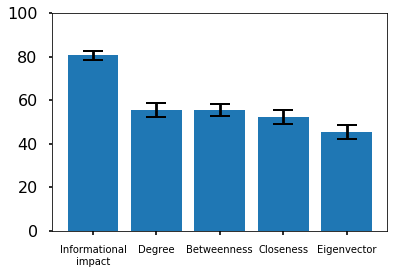

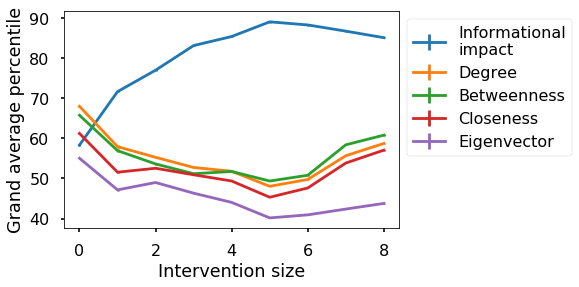

In [259]:
from scipy.stats import sem
# s = pscores.shape
scores = np.array([i for i in pscores.values()])
ndata, npulse, ntemp, _ = scores.shape
# print(scores[:, 0])
scores = scores[:, 1:]
means = scores.reshape(-1, conditions).mean(0)
sems  = sem(scores.reshape(-1, conditions), 0)
fig, ax = plt.subplots()
xrr  = np.arange(means.size)
ax.errorbar(xrr, means, 2 * sems, \
            linestyle = 'none', capsize = 10, capthick = 2, color = 'k')
ax.bar(xrr, means)
ax.set_ylim(0, 100)
ax.set_xticks(xrr)
ax.set_xticklabels(conditionLabels, fontsize = 10)
fig.show()

ascores = scores.mean(0).mean(1)
asems   = sem(sem(scores, 0), 1)

xrr = np.arange(len(ascores))
fig, ax = plt.subplots()
for cond in range(conditions):
    ax.errorbar(xrr, ascores[:, cond], asems[:, cond], label = conditionLabels[cond])
ax.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
ax.set_xlabel('Intervention size')
ax.set_ylabel('Grand average percentile')
fig.show()

Using circular_layout


/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


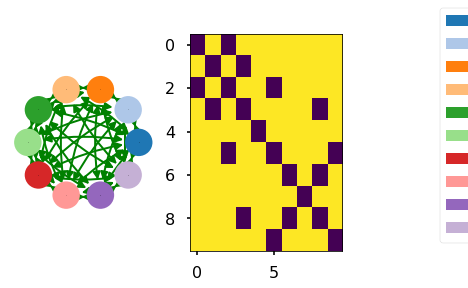

In [31]:
v = list(settings.values())
g = v[3].get('graph')
fig, (left, right) = plt.subplots(1, 2)
from Utils.plotting import addGraphPretty
addGraphPretty(g, ax = left)

right.imshow(nx.adj_matrix(g).todense(), aspect = 'auto')
left.axis('off')
fig.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
fig.show()
fig.colorbar(h)

In [327]:
from itertools import product

name, s = next(iter(settings.items()))
print(name, s.get('model'))

print(s['model'].graph)
from new import createJob

ratios = s.get('equilibrium').get('ratios')
pulses = s.get('pulseSizes')

pulses = list(product(pulses, ['', *list(model.graph.nodes())]))

nTrials = s.get('nTrials')
model = s.get('model')
combinations = product(\
                        ratios.items(), \
                        pulses, \
                        range(nTrials + 4),\
                        )


# model = model(s.get('graph'))
import sys
def new(combs):
    dirs = list(os.listdir(os.path.join(name, 'data')))
    print(dirs[0])
    for (ratio, (pulse, node), trial) in combs:
        s['trial'] = trial
        s['ratio'] = ratio
        intervention = {}
        if node:
            intervention = {node : pulse}
        model.nudges = intervention
        
        s['pulse'] = intervention
        s['model'] = model 
        d = createJob(model, s, name)
        if not os.path.exists(d):
            yield d
print(name, s.keys())
# list(new(combinations))

../Data/test/tester/2019-10-16T15:57:24.802926 <Models.FastIsing.Ising object at 0x5626a3f18ba0>

../Data/test/tester/2019-10-16T15:57:24.802926 dict_keys(['model', 'repeats', 'deltas', 'steps', 'nSamples', 'burninSamples', 'nTrials', 'modelSettings', 'tempres', 'pulseSizes', 'graph', 'equilibrium', 'trial', 'ratio', 'pulse'])


In [346]:
dirs = os.listdir(os.path.join(\
                               name, 'data',\
                ))
# dirs

s = list(settings.values())[1]
s['model'].matched = s['equilibrium']
print(s['model'].__dict__.keys())

TypeError: can't set attributes of built-in/extension type 'Models.FastIsing.Ising'